<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#skip" data-toc-modified-id="skip-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>skip</a></span></li><li><span><a href="#start-from-below" data-toc-modified-id="start-from-below-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>start from below</a></span></li><li><span><a href="#glove" data-toc-modified-id="glove-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>glove</a></span></li><li><span><a href="#on-bert-sentence-embeddings" data-toc-modified-id="on-bert-sentence-embeddings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>on bert sentence embeddings</a></span></li></ul></div>

How to resolve the nan?
- float128 not support for numpy/scipy special functions, like Gamma
- checked derivation for rho_n\[0\], it's correct
- temperature, won't influence rho_n\[0\] 
- L'Hôpital's rule? no. take derivative of beta\^alpha over alpha is still problematic
- Stirling's approximation!! cancel out some big terms and get an analytical approximation,


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
import pdb
import inspect
import scipy.io
import copy

import scipy.stats, scipy.special
from scipy.special import digamma as Digamma
from scipy.special import gamma as Gamma

from numpy.random import gamma as Gammar
from numpy.random import beta as Beta
from numpy.random import multivariate_normal as Normal


In [179]:
def GammaR(alpha, beta):
    return Gammar(alpha, scale = 1/beta)

In [180]:
def log(x):
    return np.log(x)

In [181]:
def logGamma(x):
    return np.log(Gamma(x))

In [182]:
def stirling(x):
    return np.sqrt(2*np.pi/x)*(x/np.e)**x

In [2]:
def IBP(alpha = 10, num_object = 20):
    n_init = np.random.poisson(alpha)
    Z = np.zeros(shape=(num_object,n_init),dtype = np.int32)
    Z[0,:] = 1
    K_plus = n_init
    for i in range(1,num_object):
        # Calculate probability of visiting past dishes
        Z[i,:] = Z.sum(axis = 0)/(i+1) > np.random.rand(1,K_plus)
        # Calculate the number of new dishes visited by customer i
        K_new = np.random.poisson(alpha/(i+1)) 
        Z=np.concatenate((Z,np.zeros(shape=(num_object,K_new),dtype = np.int32)), axis=1)
        Z[i,K_plus:K_plus+K_new] = 1
        # Update matrix size and dish popularity count
        K_plus = K_plus+K_new
    return Z, K_plus

# skip

In [3]:
A = np.array([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])
def gen_data(A, sigma_x = 0.5, num_object = 100):
    num_feature, num_dim = A.shape
    I = sigma_x*np.ones(num_dim)
    Z = np.zeros((num_object, num_feature))
    X = np.zeros((num_object, num_dim))
    for i in range(num_object):
        while (Z[i,:].sum() == 0):
            Z[i,:] = np.random.rand(1,num_feature) > .5
        X[i,:] = np.random.randn(num_dim)*I+Z[i,:]@A
    return X, Z

In [18]:
# generate data
sigma_x = 0.1
num_feature = 4
num_dim = 36
num_object = 500
X,Z_groundtruth = gen_data(A, sigma_x = sigma_x, num_object = num_object)

In [19]:
Z_groundtruth.shape

(500, 4)

In [23]:
X = X - X.min()
X = X/X.max()
X[X==1] = 0.999
X[X==0] = 0.001

In [24]:
np.savetxt('Z.txt', Z_groundtruth)

In [25]:
from pathlib import Path
Path("./img").mkdir(parents=True, exist_ok=True)
for i in range(num_object):
    plt.imsave('./img/'+str(i)+'.jpg', X[i,:].reshape(6,6), cmap='gray')

[0. 0. 1. 0.]
[1. 1. 1. 1.]
[0. 0. 1. 1.]
[1. 0. 0. 0.]


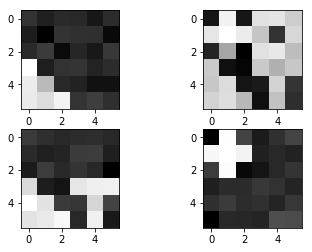

In [17]:
# show first 4 examples
for i in range(4):
    print(Z_groundtruth[i])
    plt.subplot(2,2,1+i)
    plt.imshow(X[i,:].reshape(6,6), cmap='gray')

# start from below

In [10]:
# helper class for simpler function arguments and data storage
class params_set():
    def attrs_dict(self, exclude = []):
        dic = copy.deepcopy(self.__dict__)
        for key in exclude:
            del dic[key]
        return dic
    def print_attrs(self, key = None):
        if key == None:
            key = list(self.attrs_dict().keys())
        for k in key:
            print(k+": ",self.attrs_dict()[k])
    def set_attrs_dict(self, dic): 
#         self.__dict__ = dic
        for k,v in dic.items():
            self.__dict__[k] = v

In [11]:
def compute_auxiliary_q_and_lb(eta, k):
    eta = eta[:k,:]
    temp = Digamma(eta[:,1]) \
         + np.cumsum(np.insert(Digamma(eta[:,0]),0,0))[:-1] \
         - np.cumsum(Digamma(eta[:,0]+eta[:,1])) 
    q = np.exp(temp-temp.max())
    q = q/q.sum()
    lb = (q*(temp - log(q))).sum()
    return q, lb   

In [12]:
def compute_lower_bound(X, model):
    # following section 2.2 in VIBP derivation (eq.10)
    N = model.N
    K = model.K
    D = model.D
    
    alpha_0 = model.alpha_0
    tau_A0 = model.tau_A0
    tau_n0 = model.tau_n0
    
    rho_alpha = model.rho_alpha
    rho_A = model.rho_A
    rho_n = model.rho_n
    nu = model.nu
    eta = model.eta
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    
    terms = [] # save terms seperately for debugging purpose
    
    # first three terms (eq.17), for alpha, tau_A, and tau_n
    term1 = alpha_0[1]**alpha_0[0]/Gamma(alpha_0[0]) \
            + (alpha_0[0] - 1)*(-log(rho_alpha[1]) + Digamma(rho_alpha[0])) \
            - alpha_0[0]*rho_alpha[0]/rho_alpha[1]
    terms.append(term1)
    
    term2 = tau_A0[1]**tau_A0[0]/Gamma(tau_A0[0]) \
            + (tau_A0[0] - 1)*(-log(rho_A[1]) + Digamma(rho_A[0])) \
            - tau_A0[0]*rho_A[0]/rho_A[1]
    terms.append(term2)
    
    term3 = tau_n0[1]**tau_n0[0]/Gamma(tau_n0[0]) \
            + (tau_n0[0] - 1)*(-log(rho_n[1]) + Digamma(rho_n[0])) \
            - tau_n0[0]*rho_n[0]/rho_n[1]
    terms.append(term3)
    
    # forth term (eq.18), for v
    term4 = K*(-log(rho_alpha[1]) + Digamma(rho_alpha[0])) \
            + (rho_alpha[0]/rho_alpha[1] - 1) \
                *(Digamma(eta[:,0]) - Digamma(eta.sum(axis=1))).sum()
    terms.append(term4)
    
    # fifth term (eq.19), for Z
    term5 = 0
    for k in range(K):
        q, lb = compute_auxiliary_q_and_lb(eta, k+1)
        term5 += nu[:,k].sum()*(Digamma(eta[:k+1,0]) - Digamma(eta[:k+1,0]+eta[:k+1,1])).sum() \
                + (N-nu[:,k].sum())*lb
    terms.append(term5)
    
    # sixth term (eq.24), for A
    term6 = K*D/2*(-log(rho_A[1]) + Digamma(rho_A[0])-log(2*np.pi)) \
            - rho_A[0]/2/rho_A[1] * (phi_cov.sum() + (phi_mean**2).sum()) # need to confirm the last term (phi_mean**2).sum()
    terms.append(term6)
    
    # seventh term (eq.26), for likelihood
    term7 = N*D/2*(-log(rho_n[1]) + Digamma(rho_n[0]) - log(2*np.pi)) \
            - rho_n[0]/2/rho_n[1]*( (X**2).sum() \
                                   - 2*(nu*(X@phi_mean.T)).sum() \
                                   + ((nu@phi_mean)**2).sum() - (nu**2@phi_mean**2).sum() \
                                   + (nu*(np.ones_like(X)@(phi_cov + phi_mean**2).T)).sum() )  # need to confirm the last term (nu@(phi_cov + (phi_mean**2))).sum()
    terms.append(term7)
    
    # eighth term (eq.29), for entropy
    term8_1 = log(Gamma(rho_alpha[0])/(rho_alpha[1])**rho_alpha[0]) \
            - (rho_alpha[0] - 1)*(-log(rho_alpha[1]) + Digamma(rho_alpha[0])) \
            + rho_alpha[0]
    
    # approxiate term8_2 using Stirling's approximation
    temp = log(np.sqrt(2*np.pi/rho_A[0])) + rho_A[0] * log(rho_A[0]/np.e/rho_A[1])
#     term8_2 = log(Gamma(rho_A[0])/(rho_A[1])**rho_A[0]) \
    term8_2 = temp \
            - (rho_A[0] - 1)*(-log(rho_A[1]) + Digamma(rho_A[0])) \
            + rho_A[0]
    
    # approxiate term8_3 using Stirling's approximation
    temp = log(np.sqrt(2*np.pi/rho_n[0])) + rho_n[0] * log(rho_n[0]/np.e/rho_n[1])
#     term8_3 = log(Gamma(rho_n[0])/(rho_n[1])**rho_n[0]) \
    term8_3 = temp \
            - (rho_n[0] - 1)*(-log(rho_n[1]) + Digamma(rho_n[0])) \
            + rho_n[0]
    
    # approxiate term8_4 using Stirling's approximation
    temp = 0
    for i in range(eta.shape[0]):
        temp += log( np.sqrt(2*np.pi* (eta[i,0]+eta[i,1])/(eta[i,0]*eta[i,1]))) \
                + eta[i,0]*log(eta[i,0]) + eta[i,1]*log(eta[i,1]) \
                - (eta[i,0] + eta[i,1])*log(eta[i,0] + eta[i,1])
#     temp = logGamma(eta[:,0]).sum() + logGamma(eta[:,1]).sum() \
#             - logGamma(eta.sum(axis=1)).sum() \    
    term8_4 = temp \
            - ((eta[:,0] - 1)*Digamma(eta[:,0])).sum() \
            - ((eta[:,1] - 1)*Digamma(eta[:,1])).sum() \
            + ((eta.sum(axis=1) - 2)*Digamma(eta.sum(axis=1))).sum()
    
    term8_5 = K*D/2*log(2*np.pi*np.e) + 1/2*log(phi_cov).sum()
    
    tmp_nu = nu + 0.5*(nu==0) - 0.5*(nu==1)
    term8_6 = -tmp_nu*log(tmp_nu) - (1-tmp_nu)*log(1-tmp_nu)
    term8_6 = ( term8_6 * (nu>0) * (nu<1) ).sum() 
                                   
    term8s = np.array([term8_1, term8_2, term8_3, term8_4, term8_5, term8_6])
    term8 = term8s.sum()
    terms.append(term8)
                                   
    lower_bound = np.sum(terms)
    
    return lower_bound, terms

In [13]:
def update_phi(X, model):
    N = model.N
    K = model.K
    rho_A = model.rho_A
    rho_n = model.rho_n
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
   
    for k in range(K):
        non_k_idx = np.delete(np.arange(K), k)
        mat_B = (rho_A[0]/rho_A[1] + rho_n[0]/rho_n[1] * np.ones_like(X).T@nu[:,k]) # why the mask (ones_like in my case)?
        mat_C = X.T@nu[:,k]
        for n in range(N):
            mat_C -= nu[n,k] * (nu[n,non_k_idx].reshape(-1,1)*phi_mean[non_k_idx,:]).sum(axis = 0)
#         mat_C = mat_C * (rho_n[0]*nu[:,k].sum()/rho_n[1])
        mat_C = mat_C * (rho_n[0]/rho_n[1])
        
        phi_cov[k,:] = 1/mat_B
        phi_mean[k,:] = mat_C/mat_B
    return phi_mean, phi_cov


In [14]:
def update_nu(X, model):
    N = model.N
    K = model.K
    rho_n = model.rho_n
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    eta = model.eta
    
    for k in range(K):
        _, lb = compute_auxiliary_q_and_lb(eta, k+1)
        var_theta_k = (Digamma(eta[:k+1,0]) - Digamma(eta[:k+1,:].sum(axis=1))).sum() - lb
        non_k_idx = np.delete(np.arange(K), k)
        for n in range(N):
            var_theta = var_theta_k - (rho_n[0]/2/rho_n[1]) * ((phi_cov[k,:].sum() + (phi_mean[k,:]**2).sum()) \
                           - 2*(phi_mean[k,:].T@(X[n,:].T - (nu[n, non_k_idx].reshape(-1,1) * phi_mean[non_k_idx,:]).sum(axis=0) )) )
            nu[n,k] = max(0.00001, 1/(1+np.exp(-var_theta)) )  # var_theta can be too negative, lead to overflow
    return nu       
                                     

In [15]:
def update_eta(model):
    N = model.N
    K = model.K
    nu = model.nu
    eta = model.eta
    alpha_0 = model.alpha_0
    
    sum_n_nu = nu.sum(axis=0)
    N_minus_sum_n_nu = N - sum_n_nu
    for k in range(K):
        q,_ = compute_auxiliary_q_and_lb(eta, K)
        qs = np.zeros((K,K))
        for m in range(k,K):
            qs[m,:m+1] = q[:m+1]/q[:m+1].sum()
        eta[k,0] = alpha_0[0] + sum_n_nu[k:].sum() \
                        + N_minus_sum_n_nu[k+1:]@qs[k+1:,k+1:].sum(axis=1) # confirmed with doshi's
        eta[k,1] = N_minus_sum_n_nu[k:]@qs[k:,k] + 1   # confirmed with doshi's
    return eta
        

In [16]:
def update_rho_A(model):
    K = model.K
    D = model.D
    tau_A0 = model.tau_A0
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    rho_A = model.rho_A
    
    rho_A[0] = tau_A0[0] + D*K/2
    rho_A[1] = tau_A0[1] +1/2*(phi_cov.sum() + (phi_mean**2).sum())
    return rho_A

In [17]:
def update_rho_n(X, model):
    N = model.N
    K = model.K
    D = model.D
    tau_n0 = model.tau_n0
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    rho_n = model.rho_n

    rho_n[0] = tau_n0[0] + D*N/2
    
    # X**2 may too large
    rho_n[1] = tau_n0[1] \
             + 1/2*( (X**2).sum() \
             - 2*(nu*(X@phi_mean.T)).sum() \
             + ((nu@phi_mean)**2).sum() - (nu**2@phi_mean**2).sum() \
             + (nu*(np.ones_like(X)@(phi_cov + phi_mean**2).T)).sum() )  # links to term 7 in lower bound
    return rho_n

In [18]:
def update_rho_alpha(model):
    K = model.K
    alpha_0 = model.alpha_0
    eta = model.eta
    rho_alpha = model.rho_alpha
    
    rho_alpha[0] = alpha_0[0] + K
    rho_alpha[1] = alpha_0[1] \
                 - (Digamma(eta[:,0]) - Digamma(eta[:,0]+eta[:,1])).sum()
    return rho_alpha

In [19]:
def update_parameters(X, model, maxIter = 20, thresh = 1e-2):
    itr_count = 0
    lb, _ = compute_lower_bound(X, model)
    local_lbs = []
#     print('initial lb: ',lb)
    while 1:
#         print('='*20,'itr {}'.format(itr_count),'='*20)
        itr_count += 1
        for j in np.random.permutation(6): # update in random order
            if j == 0:
                eta = update_eta(model)
                model.eta = eta
            elif j == 1:
                nu = update_nu(X, model)
                model.nu = nu
            elif j == 2:
                phi_mean, phi_cov = update_phi(X, model)
                model.phi[0,:,:] = phi_mean
                model.phi[1,:,:] = phi_cov
            elif j == 3:
                rho_A = update_rho_A(model)
                model.rho_A = rho_A
            elif j == 4:
                rho_n = update_rho_n(X, model)
                model.rho_n = rho_n
            else:
                rho_alpha = update_rho_alpha(model)
                model.rho_alpha = rho_alpha
        lb, _ = compute_lower_bound(X, model)
#         print(lb)
        if (np.std(local_lbs[-3:]) < thresh and itr_count > 3) or itr_count >= maxIter:
            break
            
    return model

In [20]:
def move(model, h, l):
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    nu = model.nu
    
    r = np.random.randint(5)
    if r == 0:  # Let h = h - l, leave l alone
        phi_mean[h,:] = phi_mean[h,:] - phi_mean[l,:]
        nu[:,h] = nu[:,h] - nu[:,l]
        nu[nu[:,h] <= 0,h] = 0.0001  # make sure it's larger than 0
    elif r == 1: # Let h = h + l, leave l alone
        phi_mean[h,:] = phi_mean[h,:] + phi_mean[l,:]
        nu[:,h] = nu[:,h] + nu[:,l]
        nu[nu[:,h] >= 1,h] = 0.9999 # make sure it's smaller than 1
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    elif r == 2: # Let h = h + l, delete l
        phi_mean[h,:] = phi_mean[h,:] + phi_mean[l,:]
        phi_mean[l,:] = 0.01*np.random.rand(phi_mean[l,:].shape[0])
        nu[:,h] = nu[:,h] + nu[:,l]
        nu[nu[:,h] >= 1,h] = 0.9999 # make sure it's smaller than 1
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    elif r == 3: # randomly reset h and l
        phi_mean[h,:] = 0.01*np.random.randn(phi_mean[h,:].shape[0])
        phi_mean[l,:] = 0.01*np.random.randn(phi_mean[l,:].shape[0])
        nu[:,h] = np.random.rand(nu[:,h].shape[0])
        nu[:,l] = np.random.rand(nu[:,l].shape[0])
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    elif r == 4: # h = h - l, l = h + l
        phi_mean[h,:], phi_mean[l,:] = phi_mean[h,:] - phi_mean[l,:], phi_mean[h,:] + phi_mean[l,:]
        nu[:,h], nu[:,l] = nu[:,h] + nu[:,l], nu[:,h] + nu[:,l]
        nu[nu[:,h] >= 1,h] = 0.9999 # make sure it's smaller than 1
        nu[nu[:,l] >= 1,l] = 0.9999 # make sure it's smaller than 1
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    model.phi[0,:,:] = phi_mean
    model.phi[1,:,:] = phi_cov
    model.nu = nu
    return model

In [31]:
def search_heuristics(X, model):
    best_lb, _ = compute_lower_bound(X, model)
    best_model_dic = model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])
    
    K = model.K
    
    for h in range(K):
        for l in np.delete(np.arange(K), h):
            new_model = copy.deepcopy(model)
            new_model = move(new_model, h, l)
            new_model = update_parameters(X, new_model, maxIter = 5)
            new_lb, _ = compute_lower_bound(X, new_model)
            if new_lb > best_lb:
                best_model_dic = new_model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])
                best_lb = new_lb
            new_model = None
    return best_lb, best_model_dic

In [107]:
def initialize_model(model, K = 6):
     # save model parameters
    model.N, model.D = X.shape
    model.K = K # set maximum truncation level

    # priors
    model.alpha_0 = np.array([1.1, 1.1])
    model.tau_A0 = np.array([1.1, 1.1])
    model.tau_n0 = np.array([1.1, 1.1])

    # variational parameters
    model.rho_alpha = np.random.rand(2)
    model.rho_A = np.random.rand(2)
    model.rho_n = np.random.rand(2)
    model.phi = np.random.rand(2, model.K, model.D) # Dim 0 for mean and dim 1 for var
                                                    # same in doshi's code, assume independent
    model.eta = np.random.rand(model.K, 2)
    model.nu = np.random.rand(model.N, model.K)
    return model

In [2]:
data_dic = scipy.io.loadmat('data.mat')
X = scipy.io.loadmat('data.mat')['X']

In [185]:
X.shape

(20, 16)

In [ ]:
from PIL import Image
im = Image.fromarray(A)
im.save("your_file.jpeg")

In [80]:
model = params_set()
# for logging purpose
model.lbs = []
model.model_sets = []
model.best_lb = 0
# recording which iteration in which run has the best lb 
model.best_model_idx = (0,0) # (best run idx, best iter idx) 


for i in range(5):
    print('='*50)
    print('='*20,'Run #{}'.format(i),'='*20)
    print('='*50)
    
    model = initialize_model(model)
    lb, _ = compute_lower_bound(X, model)
    print('initial lb: ', lb)
    
    lbs = [lb]
    model_sets = [model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])]
    iter_count = 0
    while 1:
        model = update_parameters(X, model, maxIter = 2)
        lb, _ = compute_lower_bound(X, model)
        print('after update_parameters, lb: ', lb)

        best_lb, best_model_dic = search_heuristics(X, model)
        model.set_attrs_dict(best_model_dic)
        lb, _ = compute_lower_bound(X, model)
        print('after search_heuristics, lb: ', lb)
        
        lbs.append(lb)
        model_sets.append(model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx']))
        if len(lbs) > 5 and np.std(lbs[-5:]) <1e-3:
            break
        if model.best_lb < lb or model.best_lb == 0:
            model.best_lb = lb
            model.best_model_idx = (i,iter_count)
        iter_count += 1
        
    model.model_sets.append(model_sets)
    model.lbs.append(lbs)


==================== Run #0 ====================
initial lb:  -8350.448969461288
after update_parameters, lb:  -327.3004413863892


/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


after search_heuristics, lb:  -113.78215085305942
after update_parameters, lb:  -65.39211094002661
after search_heuristics, lb:  -34.37930242606031
after update_parameters, lb:  -33.97658451755634
after search_heuristics, lb:  -20.239610666928606
after update_parameters, lb:  -20.059292256805755
after search_heuristics, lb:  -20.052725333730486
after update_parameters, lb:  -20.052448674835766
after search_heuristics, lb:  -19.249678114135428
after update_parameters, lb:  -19.175566152216106
after search_heuristics, lb:  -12.14130281871526
after update_parameters, lb:  -9.833410162434241
after search_heuristics, lb:  -9.612376631446885
after update_parameters, lb:  -9.595219014589574
after search_heuristics, lb:  -9.570142250331216
after update_parameters, lb:  -9.565997935475416
after search_heuristics, lb:  -9.560163612507694
after update_parameters, lb:  -9.558913006208485
after search_heuristics, lb:  -9.557201958256307
after update_parameters, lb:  -9.556851924026319
after search_

/Users/joey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


after search_heuristics, lb:  -7.698640218590782


In [81]:
def plot_para_history(model_sets, name):
    parameters = np.zeros((len(model_sets), model_sets[0][name].shape[0]))
    for i,model_set in enumerate(model_sets):
        parameters[i,:] = model_sets[i][name]
        
    for i in range(model_sets[0][name].shape[0]):
        plt.plot(parameters[:,i], label = str(i))
    plt.title(name)
    plt.legend()
    plt.show()

In [87]:
best_model_idx = model.best_model_idx
print(best_model_idx)

(2, 6)


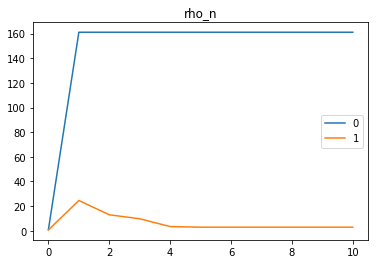

In [88]:
model_sets = model.model_sets[best_model_idx[0]]
plot_para_history(model_sets, 'rho_n')

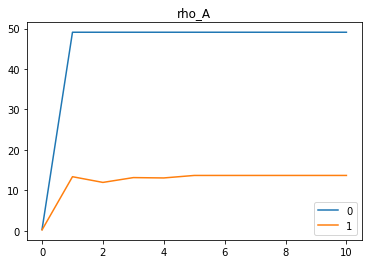

In [89]:
plot_para_history(model_sets, 'rho_A')

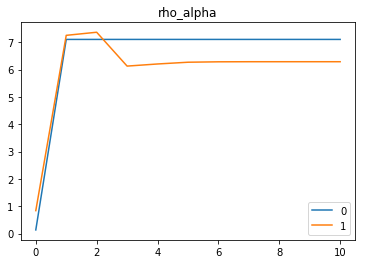

In [90]:
plot_para_history(model_sets, 'rho_alpha')

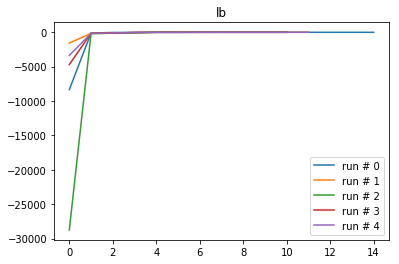

In [91]:
for i in range(5):
    plt.plot(model.lbs[i], label = 'run # '+str(i))
    plt.legend()
plt.title('lb')
plt.show()

In [95]:
best_model = model.model_sets[best_model_idx[0]][best_model_idx[1]]

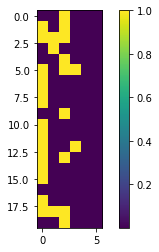

In [96]:
plt.imshow(best_model['nu'])
plt.colorbar()


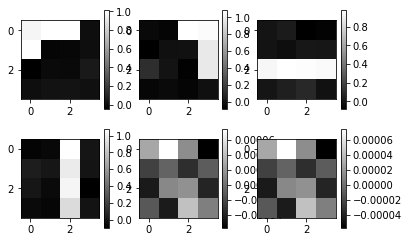

In [98]:
for j in range(6):
    plt.subplot(2,3,1+j)
    plt.imshow(best_model['phi'][0,j,:].reshape(4,4), cmap = 'gray')
    plt.colorbar()
plt.show()

# glove

In [99]:
with open('./glove/glove.6B.50d.txt') as f:
    lines = f.readlines()

In [100]:
vocab = []
embed = []
for line in lines:
    line = line.rstrip().split()
    vocab.append(line[0])
    embed.append(list(map(float, line[1:])))
embed = np.array(embed)


In [101]:
categories = ['fruits', 'animals', 'sciences', 'countries', 'colors']

In [103]:
fruits = ['apple', 'peach', 'fruit', 'cherry', 'banana', 'blueberry', 'grapefruit', 'lemon', 'mango', 'watermelon']

animals = ['tiger', 'bird', 'elephant', 'dog', 'fox', 'snake', 'deer', 'turtle', 'fish', 'donkey']

sciences = ['physics', 'chemistry', 'mathematics', 'statistics', 'geology', 'agriculture', 'biology', 'business', 'marketing', 'medicine']

countries = ['china', 'america', 'canada', 'iran', 'india', 'france', 'russia', 'argentina', 'morocco', 'australia']

colors = ['red', 'blue', 'gray', 'black', 'brown', 'yellow', 'white', 'green', 'pink', 'purple']

idx = []
word_list = []
for i,word in enumerate(vocab):
    if word in fruits or word in animals or word in sciences or word in countries or word in colors:
        print(i, word)
        idx.append(i)
        word_list.append(word)

132 china
258 business
298 white
387 france
412 russia
453 america
474 india
521 black
545 iran
603 australia
639 red
774 canada
989 green
1042 brown
1185 blue
2039 argentina
2106 fox
2120 fish
2253 marketing
2295 agriculture
2350 medicine
2381 statistics
2632 bird
2843 yellow
2926 dog
3292 apple
3566 tiger
3850 gray
4138 fruit
5318 morocco
5491 pink
5787 physics
6422 chemistry
6510 mathematics
7634 biology
7644 purple
7929 deer
9250 cherry
9311 lemon
9323 elephant
9517 snake
10705 banana
13344 geology
13841 turtle
17660 peach
20328 donkey
21638 mango
30238 grapefruit
30514 watermelon
35565 blueberry


In [104]:
fruit_idx = []
animal_idx = []
science_idx = []
country_idx = []
color_idx = []
for i,word in enumerate(word_list):
    if word in fruits:
        fruit_idx.append(i)
    if word in animals:
        animal_idx.append(i)
    if word in sciences:
        science_idx.append(i)
    if word in countries:
        country_idx.append(i)
    if word in colors:
        color_idx.append(i)

all_idx = [fruit_idx, animal_idx, science_idx, country_idx, color_idx]

len(fruit_idx), len(animal_idx), len(science_idx), len(country_idx), len(color_idx)


(10, 10, 10, 10, 10)

In [105]:
X = embed[idx,:]

In [110]:
model = params_set()
# for logging purpose
model.lbs = []
model.model_sets = []
model.best_lb = 0
# recording which iteration in which run has the best lb 
model.best_model_idx = (0,0) # (best run idx, best iter idx) 


for i in range(3):
    print('='*50)
    print('='*20,'Run #{}'.format(i),'='*20)
    print('='*50)
    
    model = initialize_model(model, K = 10)
    lb, _ = compute_lower_bound(X, model)
    print('initial lb: ', lb)
    
    lbs = [lb]
    model_sets = [model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])]
    iter_count = 0
    while 1:
        model = update_parameters(X, model, maxIter = 2)
        lb, _ = compute_lower_bound(X, model)
        print('after update_parameters, lb: ', lb)

        best_lb, best_model_dic = search_heuristics(X, model)
        model.set_attrs_dict(best_model_dic)
        lb, _ = compute_lower_bound(X, model)
        print('after search_heuristics, lb: ', lb)
        
        lbs.append(lb)
        model_sets.append(model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx']))
        if len(lbs) > 3 and np.std(lbs[-3:]) <1e-2:
            break
        if model.best_lb < lb or model.best_lb == 0:
            model.best_lb = lb
            model.best_model_idx = (i,iter_count)
        iter_count += 1
        
    model.model_sets.append(model_sets)
    model.lbs.append(lbs)


==================== Run #0 ====================
initial lb:  -22466.50046476085
after update_parameters, lb:  -3669.2035463700345


/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


after search_heuristics, lb:  -2274.1095175292494
after update_parameters, lb:  -2238.1970328829952
after search_heuristics, lb:  -2182.6030503356915
after update_parameters, lb:  -2173.8523183910506
after search_heuristics, lb:  -2148.906237034327
after update_parameters, lb:  -2148.2767252120652
after search_heuristics, lb:  -2126.6961951623757
after update_parameters, lb:  -2123.6568997200993
after search_heuristics, lb:  -2109.009913874036
after update_parameters, lb:  -2108.9349645421016
after search_heuristics, lb:  -2098.5353050902727
after update_parameters, lb:  -2098.4534860567987
after search_heuristics, lb:  -2098.435535878897
after update_parameters, lb:  -2098.4355350075643
after search_heuristics, lb:  -2098.4335836639516
after update_parameters, lb:  -2098.4332317708445
after search_heuristics, lb:  -2098.432802902835
==================== Run #1 ====================
initial lb:  -20208.058809793565
after update_parameters, lb:  -2761.6741672875296
after search_heuristic

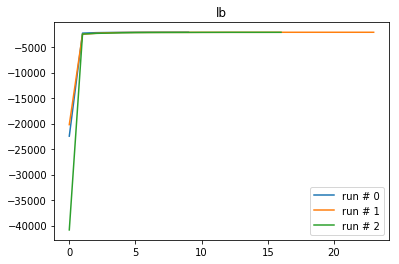

In [111]:
for i in range(3):
    plt.plot(model.lbs[i], label = 'run # '+str(i))
    plt.legend()
plt.title('lb')
plt.show()

In [116]:
best_model_idx = model.best_model_idx
print(best_model_idx)

model_sets = model.model_sets[best_model_idx[0]]


(0, 7)


In [117]:
Z = model_sets[-1]['nu']
sigma_X = model_sets[-1]['rho_n'][0] / model_sets[-1]['rho_n'][1]
sigma_A = model_sets[-1]['rho_A'][0] / model_sets[-1]['rho_A'][1]
K_plus = model_sets[-1]['K']
M = np.linalg.inv(Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
A_prox = M@Z.T@X
X_prox = Z@A_prox

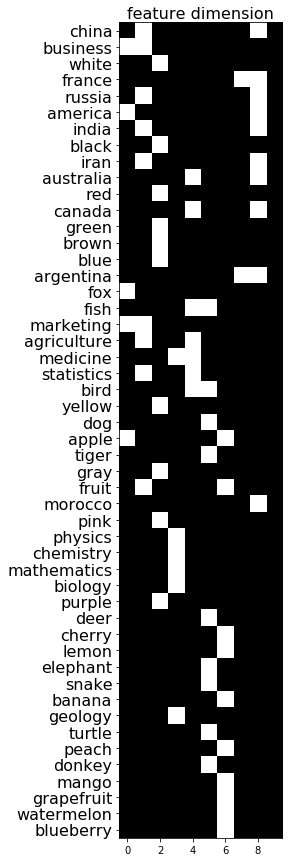

In [118]:
plt.figure(figsize=(10,15))
plt.yticks(np.arange(len(word_list)), word_list, fontsize = 16)
plt.xlabel('feature dimension', fontsize = 16)
plt.gca().xaxis.set_label_position('top')
plt.imshow(Z, cmap='gray')
plt.show()

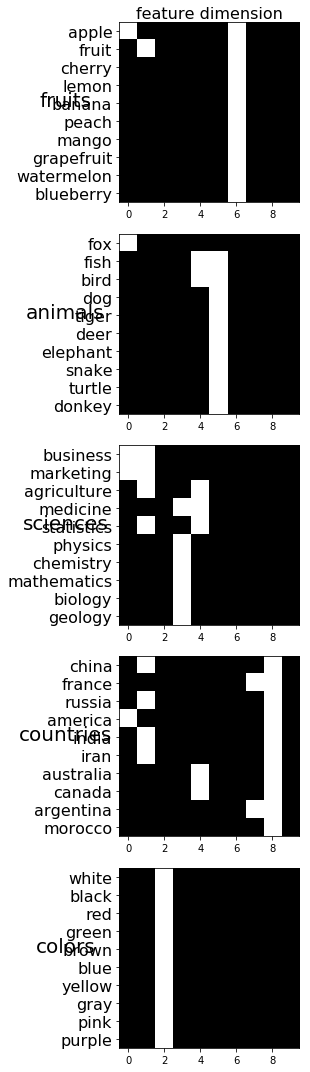

In [119]:
plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,1+i)
    plt.imshow(Z[all_idx[i],:], cmap='gray')
    plt.yticks(np.arange(len(all_idx[i])), np.array(word_list)[all_idx[i]], fontsize = 16)
    if i == 0:
        plt.xlabel('feature dimension', fontsize = 16)
    plt.gca().xaxis.set_label_position('top')
    plt.title(categories[i], x=-0.3, y=0.5, fontsize = 20)
plt.tight_layout()
plt.show()

# on bert sentence embeddings

In [120]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')


I1001 14:03:48.503644 4528848384 SentenceTransformer.py:60] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
I1001 14:03:51.575271 4528848384 SentenceTransformer.py:97] Use pytorch device: cpu


In [125]:
sentences = ['North Korea Sends Confusing Signals: Dialogue or Tension?',
             'London Police, Under Fire on Everard Murder, Respond With Safety Tips',
             'In Portugal, There Is Virtually No One Left to Vaccinate',
             'Fashion Mogul Agrees to Face Sex-Trafficking Charges in U.S.',
             'House infrastructure vote on hold as Democrats try to strike deal on broader social spending bill',
             'CEOs are at their wits’ ends — they don’t know how to get their employees back in',
             'Stocks making the biggest moves midday: Merck, Moderna, United Airlines and more',
             'Alaska Airlines tells employees they need Covid vaccinations under federal rules',
             'Rising cases and deaths test Singapore’s pivot to treat Covid as endemic',
             'Amazon hardware chief says Astro home robot started as a security device and ‘evolved’',
             'Facebook used Big Tobacco playbook to exploit teens and children, senators say'
            ]
sentence_embeddings = model.encode(sentences)


/Users/joey/anaconda3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [127]:
sentence_embeddings

array([[-0.01703846,  0.04693829,  0.023722  , ...,  0.01539291,
        -0.09617949, -0.03351739],
       [ 0.00993483,  0.06485876, -0.0134256 , ..., -0.01853283,
        -0.01734944,  0.04869064],
       [ 0.06575372,  0.05510629, -0.06001321, ..., -0.03737281,
        -0.00201545,  0.00608888],
       ...,
       [-0.00420298, -0.01088682, -0.01527512, ..., -0.03880221,
         0.01342504,  0.07348343],
       [-0.03179686,  0.02309716, -0.02921871, ...,  0.04169037,
         0.01917455,  0.043859  ],
       [-0.00658451,  0.09564114, -0.03408258, ..., -0.00178985,
         0.01740042,  0.03228514]], dtype=float32)

In [133]:
sentence_embeddings.max()

0.16871125

In [126]:
sentence_embeddings.shape

(11, 384)

In [134]:
X = sentence_embeddings/sentence_embeddings.max()

In [158]:
model = params_set()
# for logging purpose
model.lbs = []
model.model_sets = []
model.best_lb = 0
# recording which iteration in which run has the best lb 
model.best_model_idx = (0,0) # (best run idx, best iter idx) 
num_runs = 1

for i in range(num_runs):
    print('='*50)
    print('='*20,'Run #{}'.format(i),'='*20)
    print('='*50)
    
    model = initialize_model(model, K = 12)
    lb, _ = compute_lower_bound(X, model)
    print('initial lb: ', lb)
    
    lbs = [lb]
    model_sets = [model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx'])]
    iter_count = 0
    while 1:
        model = update_parameters(X, model, maxIter = 2)
        lb, _ = compute_lower_bound(X, model)
        print('after update_parameters, lb: ', lb)

        best_lb, best_model_dic = search_heuristics(X, model)
        model.set_attrs_dict(best_model_dic)
        lb, _ = compute_lower_bound(X, model)
        print('after search_heuristics, lb: ', lb)
        
        lbs.append(lb)
        model_sets.append(model.attrs_dict(exclude = ['lbs','model_sets', 'best_lb', 'best_model_idx']))
        if len(lbs) > 3 and np.std(lbs[-3:]) <1e-2:
            break
        if model.best_lb < lb or model.best_lb == 0:
            model.best_lb = lb
            model.best_model_idx = (i,iter_count)
        iter_count += 1
        
    model.model_sets.append(model_sets)
    model.lbs.append(lbs)


==================== Run #0 ====================
initial lb:  -82611.23210531393


/Users/joey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/joey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


after update_parameters, lb:  -990.9431637063035
after search_heuristics, lb:  -975.0470845957892
after update_parameters, lb:  -972.2901305771567
after search_heuristics, lb:  -968.2155898157192
after update_parameters, lb:  -967.367768384362
after search_heuristics, lb:  -965.9350882222541
after update_parameters, lb:  -965.5638597333972
after search_heuristics, lb:  -964.8675679008019
after update_parameters, lb:  -964.6699979446338
after search_heuristics, lb:  -964.347296978821
after update_parameters, lb:  -964.3000603493002
after search_heuristics, lb:  -964.2608875818769
after update_parameters, lb:  -964.2569912537426
after search_heuristics, lb:  -964.2538768812088
after update_parameters, lb:  -964.2535472275925


KeyboardInterrupt: 

In [159]:
best_model_idx = model.best_model_idx
best_model_idx

(0, 6)

In [161]:
best_model = model.model_sets[best_model_idx[0]][best_model_idx[1]]

IndexError: list index out of range

In [173]:
best_model = model_sets[0]

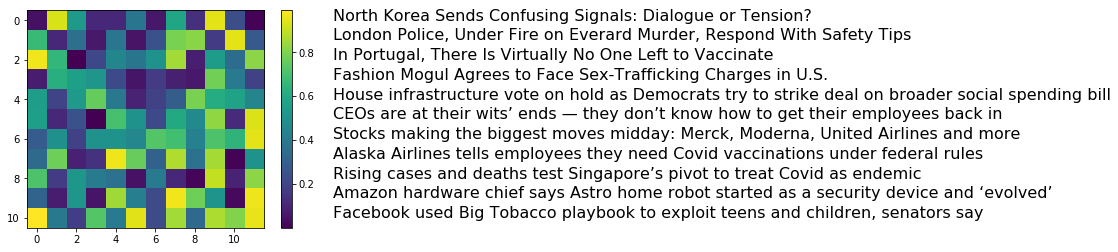

In [177]:
plt.imshow(best_model['nu'])
for i, s in enumerate(sentences):
    plt.text(15,i,s, fontsize = 16)
plt.colorbar()
